In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from filterpy.kalman import KalmanFilter
tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.   # time step 1 second

tracker.F = np.array([[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]])


In [2]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.05)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[0.0125 0.025  0.     0.    ]
 [0.025  0.05   0.     0.    ]
 [0.     0.     0.0125 0.025 ]
 [0.     0.     0.025  0.05  ]]


In [3]:
tracker.H = np.array([[1/0.3048, 0, 0,        0],
                      [0,        0, 1/0.3048, 0]])

In [4]:

tracker.R = np.array([[5, 0],
                      [0, 5]])
print(tracker.R)

[[5 0]
 [0 5]]


In [5]:
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500
tracker.P

array([[500.,   0.,   0.,   0.],
       [  0., 500.,   0.,   0.],
       [  0.,   0., 500.,   0.],
       [  0.,   0.,   0., 500.]])

In [6]:
from numpy.random import randn
import copy
class PosSensor1(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

In [7]:
import book_plots as bp

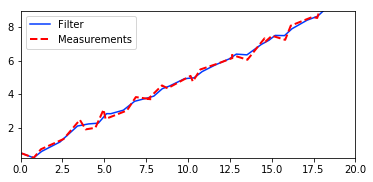

In [8]:
def tracker1():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.0   # time step

    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1/0.3048, 0, 0, 0],
                          [0, 0, 1/0.3048, 0]])

    tracker.R = np.eye(2) * 5
    q = Q_discrete_white_noise(dim=2, dt=dt, var=0.05)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0]]).T
    tracker.P = np.eye(4) * 500.
    return tracker

# simulate robot movement
N = 30
sensor = PosSensor1 ([0, 0], (2, 1), 1.)
zs = np.array([np.array([sensor.read()]).T for _ in range(N)])

# run filter
robot_tracker = tracker1()
mu, cov, _, _ = tracker.batch_filter(zs)

# plot results
zs *= .3048 # convert to meters
bp.plot_filter(mu[:, 0], mu[:, 2])
bp.plot_measurements(zs[:, 0], zs[:, 1])
plt.legend(loc=2)
plt.gca().set_aspect('equal')
plt.xlim((0, 20));

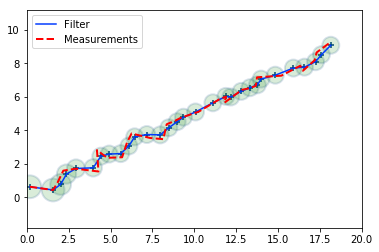

In [9]:
from filterpy.stats import plot_covariance_ellipse

# simulate robot movement
N = 30
sensor = PosSensor1([0, 0], (2, 1), 1.)
zs = np.array([np.array([sensor.read()]).T for _ in range(N)])

# run filter
robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)

for x, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
    plot_covariance_ellipse(mean, cov=cov, fc='g', alpha=0.15)
      
# plot results
zs *= .3048 # convert to meters
bp.plot_filter(mu[:, 0], mu[:, 2])
bp.plot_measurements(zs[:, 0], zs[:, 1])
plt.legend(loc=2)
plt.gca().set_aspect('equal')
plt.xlim((0, 20));

In [10]:
np.diag(tracker.P)


array([0.25675401, 0.10095634, 0.25675401, 0.10095634])

[[0.25675401 0.10192183]
 [0.10192183 0.10095634]]


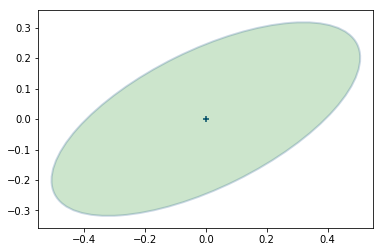

In [11]:
c = tracker.P[0:2, 0:2]
print(c)
plot_covariance_ellipse((0, 0), cov=c, fc='g', alpha=0.2)

In [12]:
tracker.P[2:4, 0:2]


array([[0., 0.],
       [0., 0.]])

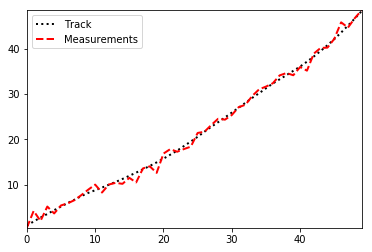

In [13]:
class ConstantVelocityObject(object):
    def __init__(self, x0=0, vel=1., noise_scale=0.06):
        self.x = x0
        self.vel = vel
        self.noise_scale = noise_scale

    def update(self):
        self.vel += randn() * self.noise_scale
        self.x += self.vel
        return (self.x, self.vel)

def sense(x, noise_scale=1.):
    return x[0] + randn()*noise_scale

np.random.seed(124)
obj = ConstantVelocityObject()

xs, zs = [], []
for i in range(50):
    x = obj.update()
    z = sense(x)
    xs.append(x)
    zs.append(z)

xs = np.asarray(xs)
bp.plot_track(xs[:, 0])
bp.plot_measurements(range(len(zs)), zs)
plt.legend(loc='best');

In [14]:
def ZeroOrderKF(R, Q, P=20):
    """ Create zero order Kalman filter. Specify R and Q as floats."""
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([0.])
    kf.R *= R
    kf.Q *= Q
    kf.P *= P
    kf.F = np.eye(1)
    kf.H = np.eye(1)
    return kf

In [15]:

def FirstOrderKF(R, Q, dt):
    """ Create zero order Kalman filter. Specify R and Q as floats."""
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P *= np.array([[100, 0], [0, 1]])
    kf.R *= R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0., 1]])
    kf.H = np.array([[1., 0]])
    return kf

In [16]:
def SecondOrderKF(R_std, Q, dt):
    """ Create zero order Kalman filter. Specify R and Q as floats."""
    kf = KalmanFilter(dim_x=3, dim_z=1)
    kf.x = np.zeros(3)
    kf.P[0, 0] = 100
    kf.P[1, 1] = 1
    kf.P[2, 2] = 1
    kf.R *= R_std**2
    kf.Q = Q_discrete_white_noise(3, dt, Q)
    kf.F = np.array([[1., dt, .5*dt*dt],
                     [0., 1.,       dt],
                     [0., 0.,       1.]])
    kf.H = np.array([[1., 0., 0.]])
    return kf

In [17]:
def simulate_system(Q, count):
    obj = ConstantVelocityObject(x0=.0, vel=0.5, noise_scale=Q)
    xs, zs = [], []
    for i in range(count):
        x = obj.update()
        z = sense(x)
        xs.append(x)
        zs.append(z)
    return np.asarray(xs), np.asarray(zs)

In [18]:

def filter_data(kf, zs):
    xs, ps = [], []
    for z in zs:
        kf.predict()
        kf.update(z)

        xs.append(kf.x)
        ps.append(kf.P.diagonal()) # just save variances
    
    return np.asarray(xs), np.asarray(ps)

In [19]:
def plot_kf_output(xs, filter_xs, zs, title=None, aspect_equal=True):
    bp.plot_filter(filter_xs[:, 0])
    bp.plot_track(xs[:, 0])
    
    if zs is not None:
        bp.plot_measurements(zs)
    bp.show_legend()
    bp.set_labels(title=title, x='meters', y='time (sec)')
    if aspect_equal:
        plt.gca().set_aspect('equal')
    plt.xlim((-1, len(xs)))
    plt.show()

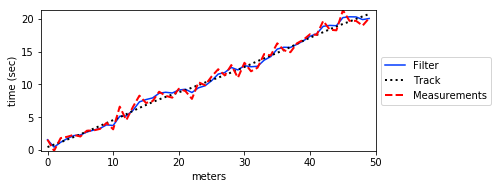

In [20]:
R, Q = 1, 0.03
xs, zs = simulate_system(Q=Q, count=50)

kf = FirstOrderKF(R, Q, dt=1)
filter_xs1, ps1 = filter_data(kf, zs)

plt.figure()
plot_kf_output(xs, filter_xs1, zs)


In [21]:
def plot_residuals(xs, filter_xs, Ps, title, y_label, stds=1):
    res = xs - filter_xs
    plt.plot(res)
    bp.plot_residual_limits(Ps, stds)
    bp.set_labels(title, 'time (sec)', y_label)
    plt.show()

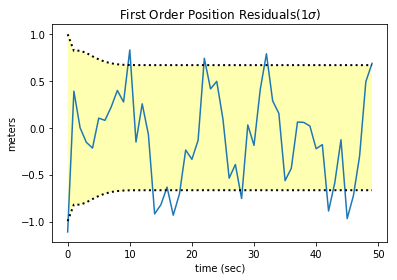

In [22]:
plot_residuals(xs[:, 0], filter_xs1[:, 0], ps1[:, 0], 
               title='First Order Position Residuals(1$\sigma$)',
               y_label='meters')   


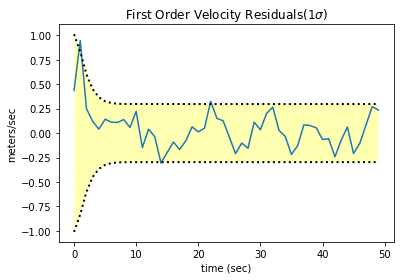

In [23]:
plot_residuals(xs[:, 1], filter_xs1[:, 1], ps1[:, 1], 
               title='First Order Velocity Residuals(1$\sigma$)',
               y_label='meters/sec')  

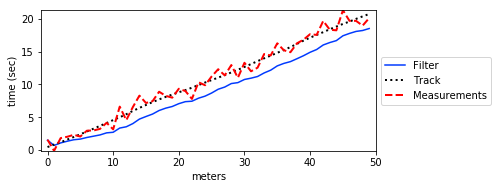

In [24]:
kf0 = ZeroOrderKF(R, Q)
filter_xs0, ps0 = filter_data(kf0, zs)
plot_kf_output(xs, filter_xs0, zs)

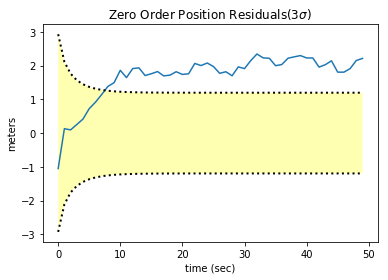

In [25]:
plot_residuals(xs[:, 0], filter_xs0[:, 0], ps0[:, 0], 
               title='Zero Order Position Residuals(3$\sigma$)',
               y_label='meters',
               stds=3)


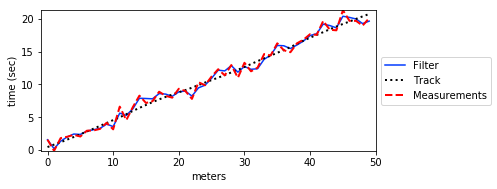

In [26]:
kf2 = SecondOrderKF(R, Q, dt=1)
filter_xs2, ps2 = filter_data(kf2, zs)
plot_kf_output(xs, filter_xs2, zs)

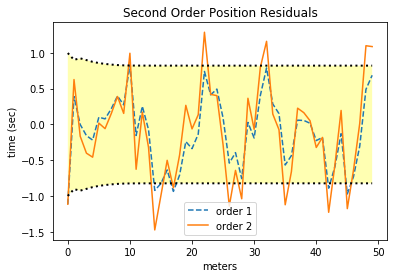

In [27]:
res = xs[:, 0] - filter_xs2[:, 0]
res1 = xs[:, 0] - filter_xs1[:, 0]

plt.plot(res1, ls="--", label='order 1')
plt.plot(res, label='order 2')
bp.plot_residual_limits(ps2[:, 0])
bp.set_labels('Second Order Position Residuals', 'meters', 'time (sec)')
plt.legend();


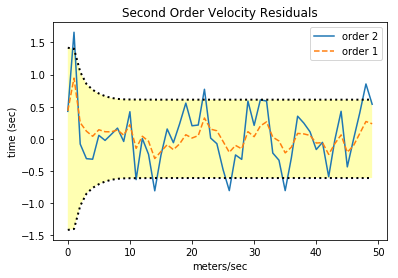

In [28]:
res = xs[:, 1] - filter_xs2[:, 1]
res1 = xs[:, 1] - filter_xs1[:, 1]
plt.plot(res, label='order 2')
plt.plot(res1, ls='--', label='order 1')
bp.plot_residual_limits(ps2[:, 1])
bp.set_labels('Second Order Velocity Residuals', 'meters/sec', 'time (sec)')
plt.legend();


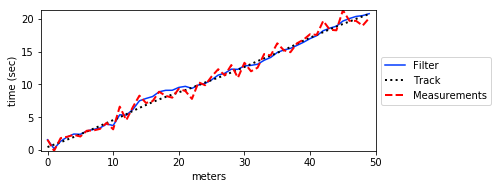

In [29]:
kf2 = SecondOrderKF(R, 0, dt=1)
filter_xs2, ps2 = filter_data(kf2, zs)
plot_kf_output(xs, filter_xs2, zs)

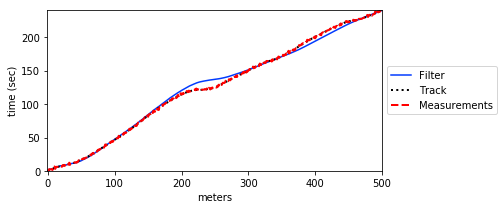

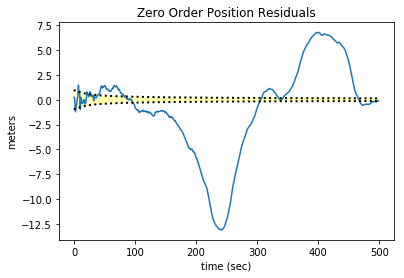

In [30]:

np.random.seed(25944)
xs500, zs500 = simulate_system(Q=Q, count=500)

kf2 = SecondOrderKF(R, 0, dt=1)
filter_xs2, ps2 = filter_data(kf2, zs500)

plot_kf_output(xs500, filter_xs2, zs500)
plot_residuals(xs500[:, 0], filter_xs2[:, 0], ps2[:, 0], 
               'Zero Order Position Residuals',
               'meters') 

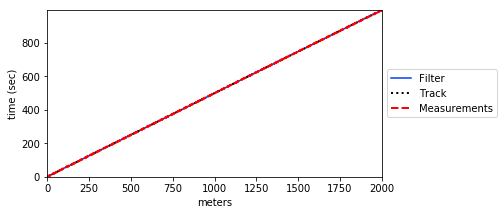

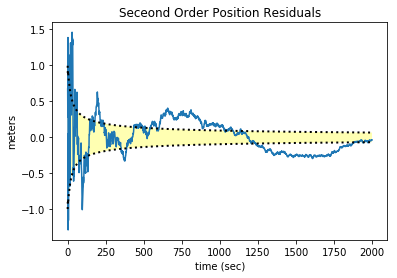

In [31]:
np.random.seed(32594)
xs2000, zs2000 = simulate_system(Q=0.0001, count=2000)

kf2 = SecondOrderKF(R, 0, dt=1)
filter_xs2, ps2 = filter_data(kf2, zs2000)

plot_kf_output(xs2000, filter_xs2, zs2000)
plot_residuals(xs2000[:, 0], filter_xs2[:, 0], ps2[:, 0], 
               'Seceond Order Position Residuals',
               'meters') 

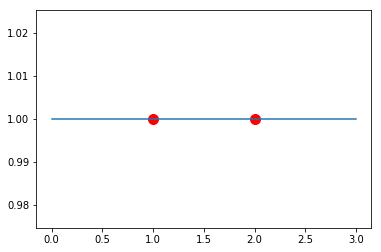

In [32]:
plt.scatter([1, 2], [1, 1], s=100, c='r')
plt.plot([0, 3], [1, 1]);

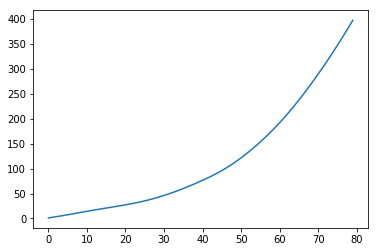

In [33]:
class ConstantAccelerationObject(object):
    def __init__(self, x0=0, vel=1., acc=0.1, acc_noise_scale=.1):
        self.x = x0
        self.vel = vel
        self.acc = acc
        self.acc_noise_scale = acc_noise_scale
    
    def update(self):
        self.acc += randn() * self.acc_noise_scale       
        self.vel += self.acc
        self.x += self.vel
        return (self.x, self.vel, self.acc)
  
R, Q = 6., 0.02
def simulate_acc_system(R, Q, count):
    obj = ConstantAccelerationObject(acc_noise_scale=Q)
    zs = []
    xs = []
    for i in range(count):
        x = obj.update()
        z = sense(x, R)
        xs.append(x)
        zs.append(z)
    return np.asarray(xs), zs

np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)
plt.plot(xs[:, 0]);

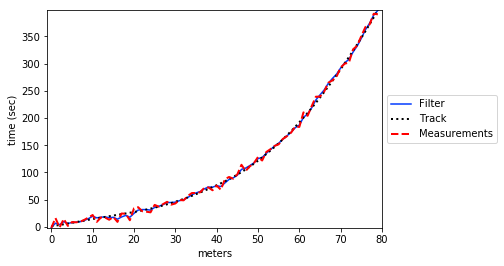

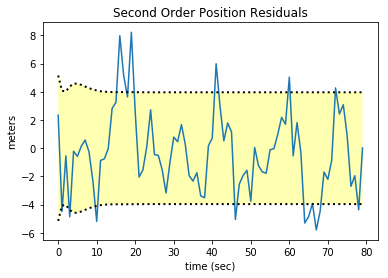

In [34]:
np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)

kf2 = SecondOrderKF(R, Q, dt=1)
fxs2, ps2 = filter_data(kf2, zs)

plot_kf_output(xs, fxs2, zs, aspect_equal=False)
plot_residuals(xs[:, 0], fxs2[:, 0], ps2[:, 0], 
               'Second Order Position Residuals',
               'meters') 

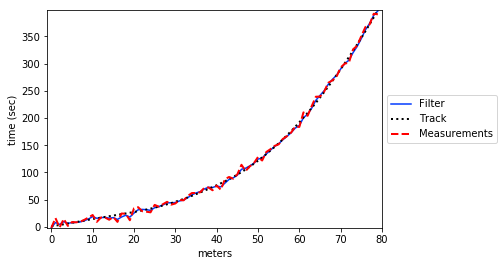

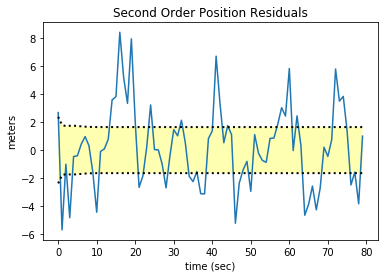

In [35]:

kf2 = FirstOrderKF(R, Q * 10, dt=1)
fxs2, ps2 = filter_data(kf2, zs)

plot_kf_output(xs, fxs2, zs, aspect_equal=False)
plot_residuals(xs[:, 0], fxs2[:, 0], ps2[:, 0], 
               'Second Order Position Residuals',
               'meters') 

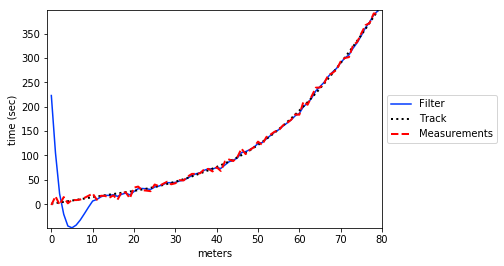

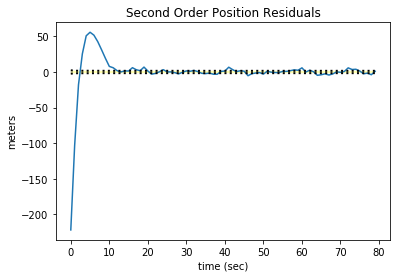

In [36]:
kf1 = FirstOrderKF(R, Q * 10000, dt=1)
fxs1, ps1 = filter_data(kf2, zs)

plot_kf_output(xs, fxs1, zs, aspect_equal=False)
plot_residuals(xs[:, 0], fxs1[:, 0], ps2[:, 0], 
               'Second Order Position Residuals',
               'meters') 

fusion std: 0.391


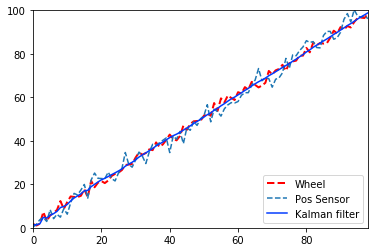

In [37]:
from numpy import array, asarray
import numpy.random as random

def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
    dt = 0.1
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.F = array([[1., dt], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.Q *= array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * 0.02
    kf.P *= 100
    kf.R[0, 0] = wheel_sigma**2
    kf.R[1, 1] = ps_sigma**2 

    random.seed(1123)
    xs, zs, nom = [], [], []
    for i in range(1, 100):
        m0 = i + randn()*wheel_sigma
        m1 = i + randn()*ps_sigma
        z = array([[m0], [m1]])

        kf.predict()
        kf.update(z)

        xs.append(kf.x.T[0])
        zs.append(z.T[0])
        nom.append(i)

    xs = asarray(xs)
    zs = asarray(zs)
    nom = asarray(nom)
    
    res = nom - xs[:, 0]
    print('fusion std: {:.3f}'.format(np.std(res)))
    if do_plot:
        bp.plot_measurements(zs[:, 0], label='Wheel')
        plt.plot(zs[:, 1], linestyle='--', label='Pos Sensor')
        bp.plot_filter(xs[:, 0], label='Kalman filter')
        plt.legend(loc=4)
        plt.ylim(0, 100)

fusion_test(1.5, 3.0)

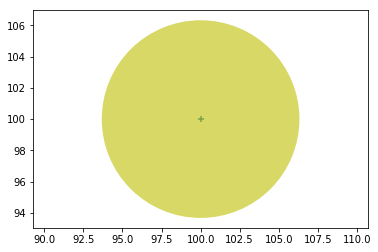

In [39]:

from kf_design_internal import sensor_fusion_kf, set_radar_pos

kf = sensor_fusion_kf()
x0, p0 = kf.x.copy(), kf.P.copy()
plot_covariance_ellipse(x0, cov=p0, fc='y', ec=None, alpha=0.6)

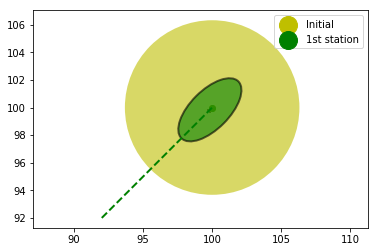

In [40]:
from math import radians

# set the error of the radar's bearing and distance
kf.R[0, 0] = radians (.5)**2
kf.R[1, 1] = 3.**2

# compute position and covariance from first radar station
set_radar_pos((50, 50))
dist = (50**2 + 50**2) ** 0.5
kf.predict()
kf.update([radians(45), dist])

# plot the results
x1, p1 = kf.x.copy(), kf.P.copy()

plot_covariance_ellipse(x0, p0, fc='y', ec=None, alpha=0.6)
plot_covariance_ellipse(x1, p1, fc='g', ec='k', alpha=0.6)

plt.scatter([100], [100], c='y', label='Initial')
plt.scatter([100], [100], c='g', label='1st station')
plt.legend(scatterpoints=1, markerscale=3)
plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--');

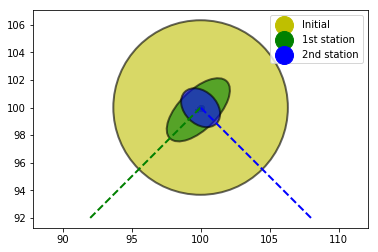

In [41]:
set_radar_pos((150, 50))
kf.predict()
kf.update([radians(135), dist])

plot_covariance_ellipse(x0, p0, fc='y', ec='k', alpha=0.6)
plot_covariance_ellipse(x1, p1, fc='g', ec='k', alpha=0.6)
plot_covariance_ellipse(kf.x, kf.P, fc='b', ec='k', alpha=0.6)

plt.scatter([100], [100], c='y', label='Initial')
plt.scatter([100], [100], c='g', label='1st station')
plt.scatter([100], [100], c='b', label='2nd station')
plt.legend(scatterpoints=1, markerscale=3)
plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--')
plt.plot([108, 100], [92, 100], c='b', lw=2, ls='--');

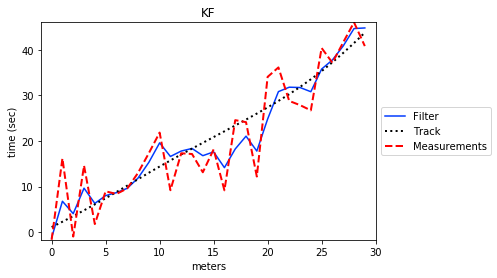

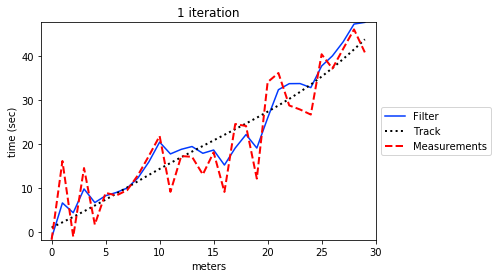

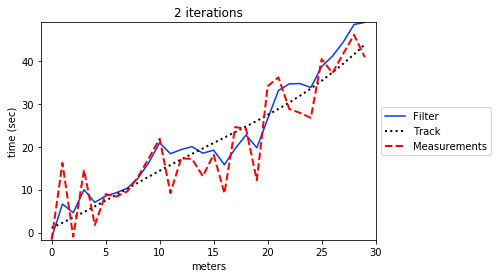

In [43]:

np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=30)

kf0 = SecondOrderKF(R, Q, dt=1)
kf1 = SecondOrderKF(R, Q, dt=1)
kf2 = SecondOrderKF(R, Q, dt=1)

# Filter measurements
fxs0, ps0 = filter_data(kf0, zs)

# filter twice more, using P as error
fxs1, ps1, _, _ = kf1.batch_filter(fxs0[:, 0], ps0[:, 0])
fxs2, _, _, _ = kf2.batch_filter(fxs1[:, 0], ps1[:, 0, 0])

plot_kf_output(xs, fxs0, zs, title='KF', aspect_equal=False)
plot_kf_output(xs, fxs1, zs, title='1 iteration', aspect_equal=False)
plot_kf_output(xs, fxs2, zs, title='2 iterations', aspect_equal=False)

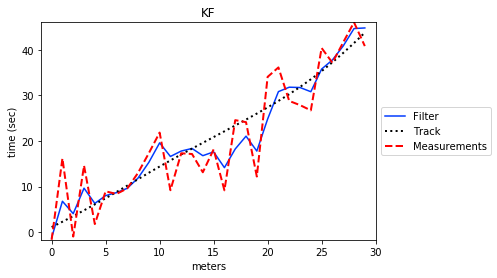

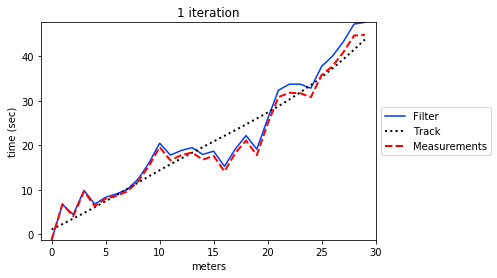

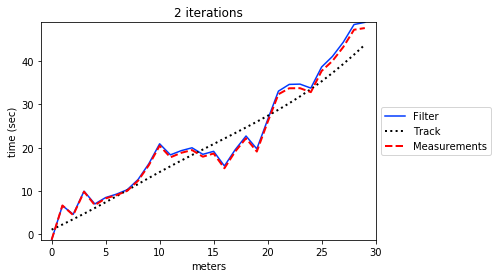

In [44]:
plot_kf_output(xs, fxs0, zs, title='KF', aspect_equal=False)
plot_kf_output(xs, fxs1, fxs0[:, 0], title='1 iteration', aspect_equal=False)
plot_kf_output(xs, fxs2, fxs1[:, 0], title='2 iterations', aspect_equal=False)

In [46]:
fusion_test(1.5, 3.0, do_plot=False)
fusion_test(1.5, 1e80, do_plot=False)

fusion std: 0.391
fusion std: 0.438


std: 40.340


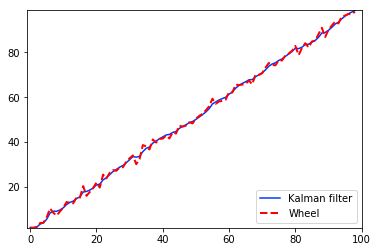

In [47]:
wheel_sigma = 1.5
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.F = array([[1., dt], [0., 1.]])
kf.H = array([[1., 0.]])
kf.x = array([[0.], [1.]])
kf.Q *= 0.01
kf.P *= 100
kf.R[0, 0] = wheel_sigma**2

random.seed(1123)
nom = range(1, 100)
zs = np.array([i + randn()*wheel_sigma for i in nom])
xs, _, _, _ = kf.batch_filter(zs)

res = nom - xs[:, 0]
print('std: {:.3f}'.format(np.std(res)))

bp.plot_filter(xs[:, 0], label='Kalman filter')
bp.plot_measurements(zs, label='Wheel')
plt.legend(loc=4)
plt.xlim((-1, 100));

In [52]:
def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
    dt = 0.25
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.F = array([[1., dt], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.Q *= array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * 0.02
    kf.P *= 100
    kf.R[0, 0] = wheel_sigma**2
    kf.R[1, 1] = ps_sigma**2 

    random.seed(1123)
    xs = []
    zs_wheel = []
    zs_ps = []
    nom = []
    for i in range(1, 101):
        
        if i % 4 == 0:
            m0 = i + randn()*wheel_sigma
            m1 = i + randn()*ps_sigma
            z = array([[m0], [m1]])
            kf.H = array([[1., 0.], [1., 0.]])
            R = np.eye(2)
            R[0, 0] = wheel_sigma**2
            R[1, 1] = ps_sigma**2      
            
            zs_wheel.append(m0)
            zs_ps.append((i, m1))
        else:  
            m0 = i + randn()*wheel_sigma
            z = array([m0])
            kf.H = array([[1., 0.]])
            R = np.eye(1) * wheel_sigma**2
            zs_wheel.append(m0)

        kf.predict()
        kf.update(z, R)

        xs.append(kf.x.T[0])
        nom.append(i)

    xs = asarray(xs)
    nom = asarray(nom)

    res = nom - xs[:, 0]
    print('fusion std: {:.3f}'.format(np.std(res)))
    if do_plot:
        bp.plot_measurements(zs_wheel,  label='Wheel')
        plt.plot(*zip(*zs_ps), linestyle='--', label='Pos Sensor')
        bp.plot_filter(xs[:, 0], label='Kalman filter')
        plt.legend(loc=4)
        plt.ylim(0, 100)

fusion_test(1.5, 3.0);

ValueError: z must be convertible to shape (2, 1)